# ITERATIVE PRISONER'S DILEMMA


### INTRODUCTION

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function.

### STRATEGIES
The implemented strategies are the following:

* **Nice guy**: always cooperate (the function's output is always $u_C$)
* **Bad guy**: always defects 
* **Mainly nice**: randomly defects $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defects $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **Tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move
* **Random guy**: randomly defects or cooperates
* **Resentful guy**: cooperates until the opponent defects once, then always defects
* **Trusting guy**: initially is like random guy (coop/defect at k=50%), then updates k according to match history (% of coop over the total)
* **Balancing guy**: cooperates only for an even number of cooperations in the history, otherwise defects
* **Mid Resentful guy**: usually cooperates, unless the opponent has defected in any of the previous 3 moves (in this case defects)
* **Reverse Tit-for-tat**: it does the reverse of Tft. It defects on the first move, then plays the reverse of the opponent’s last move.
* **Scamming Guy**: start by defecting, then cooperating two times; for the following turns chose the optimal condition based on how the adversary did

The template for the functions implementing the strategies is:
```python
def strategy( round_number, match_history, player_index) : 
    move = defect or cooperate
    return move 
```


In [1]:
# IMPORT BLOCK:____________________________________________

import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

In [2]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )
# percentage of defect for mainly nice ( and 1-k percentage of cooperate for mainly bad) Global Variable
k = 0.25

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

### STRATEGIES CODE

In [3]:
def nice_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    return move 

def bad_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = defect
    return move 

def mainly_nice( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < k ) : move = defect
    else :         move = cooperate
    return         move

def mainly_bad( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

def random_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < 0.5 ) : move = defect
    else :           move = cooperate
    return           move

def tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = cooperate
    else :                     move = match_history[ round_number - 1 ][ 1 - player_index ]
    return                     move

def resentful_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    if ( round_number > 0 ) :
        for res in match_history : 
            # if any result matching a defect is found, the move is set to defect
            if np.array_equal( res[ 1 - player_index  ], defect ) : move = defect
            # if a defect is found, he would break    
            break
    return move

def trusting_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # starting trust
    k_t = 0.5
    # environmental trust
    if ( round_number > 0 ) :
        # number of cooperative behaviour met
        coop = 0. 
        # increase the value of cooperation by one each cooperation (element 0) seen from the other player (index 1-player_index)
        for res in match_history : coop += res[ 1 - player_index  ][ 0 ]
        # normalizing result over the match history
        k_t = coop / len( match_history )
    u = npr.random( )
    if ( u > k_t ) : move = defect
    else :         move = cooperate
    return         move

def balancing_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    move = defect
    if ( round_number > 0 ) :
        # total cooperation seen
        coop = 0
        # increase the value of cooperation by one each cooperation (element 0) seen from each side during the match
        for res in match_history : coop += ( res[ 0 ][ 1 ] + res[ 1 ][ 1 ])
        if ( ( coop % 2 ) == 0 ) : move = cooperate
    return                         move

def mid_resentful( round_number = 0, match_history = [[]], player_index = 0):
    move = cooperate
    # selecting the oldest round to check, 3 before the current one if possible, the starting round otherwise
    start = max(0, round_number - 3)
    for round_i in range( start, round_number ):
        # checking if one of the previous move of the opponent (1-player_index) mach a defect
        if np.array_equal( match_history[round_i][1 - player_index], defect ):   
            move = defect
            # if a result is found, the cycle can break
            break
    return move

def reverse_tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = defect
                               # in this way i obtain the opposite move: [1,1] - [1,0] = [0,1] and [1,1] - [0,1] = [1,0]
    else :                     move = [1,1] - match_history[ round_number - 1 ][ 1 - player_index ]  
    return                     move

def scamming_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # default move is defect
    move =  defect
    # selecting first tree moves
    if ( round_number == 0 )   : 
        # print( f"round {round_number}: I defect" )
        move = defect
    elif ( round_number == 1 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    elif ( round_number == 2 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    else :
        # counting number of matching cooperation issues and defected from 0
        matching_coop = 0
        scammed = 0
        # deciding how much history to check
        first_r = npr.randint( 3, ( round_number + 1 ), dtype = int )
        # print( first_r )
        # searching over match history
        for i in range( round_number ) :
            # checking if the result cooperate, cooperate occurs
            if( np.array_equal( match_history[i][0], cooperate ) and np.array_equal( match_history[i][1], cooperate ) ) :
                matching_coop += 1
            # checking if the result cooperate, defect occurs in favour of the opposite side
            elif( np.array_equal( match_history[i][1 - player_index], defect ) and np.array_equal( match_history[i][player_index], cooperate ) ) :
                scammed += 1
        # checking if the opponent has always cooperated or if he has defected even once
        if( np.all( np.array_equiv( np.array( [ match_history[i][ 1 - player_index ] for i in range( ( round_number - first_r ), round_number ) ] ) , cooperate ) ) ) :
            # print( f"The rival is too good, I defect" )
            move = defect
        elif( matching_coop >= scammed ) : 
            # print( f"The rival is smart, I cooperate" )
            move = cooperate
    return move

# dictionary of all strategies
strategies = {
    'NiceGuy' : nice_guy,
    'BadGuy' : bad_guy,
    'MainlyNice' : mainly_nice,
    'MainlyBad' : mainly_bad,
    'TitForTat' : tit_for_tat,
    'RandomGuy' : random_guy,
    'ResentfulGuy' : resentful_guy,
    'TrustingGuy' : trusting_guy,
    'Thanos' : balancing_guy,
    'MidResentful': mid_resentful,
    'ReverseTft': reverse_tit_for_tat,
    'ScammingGuy' : scamming_guy,
}

### ROUND AND MATCH FUNCTIONS
We write here the functions used to simulate a single round and a match. A round is a single game between two players, each one with an assigned strategy. The **round** function returns the single score for each player. A match is a sequence of N rounds between two players. The function **match** returns the total score of the match for each player. It is simply obtained by the sum of the single scores of the rounds.

In [4]:
# function to play one round 1 vs 1 for two different* strategies players
def round( key_1, key_2, round_number, match_history, M = Payoff ) :
    # computing minimum and maximum reward for normalization
    s = np.dot( cooperate, M.dot(defect) )
    t = np.dot( defect, M.dot(cooperate) )
    # getting strategies from dictionary
    S_1 = strategies[ key_1 ]
    S_2 = strategies[ key_2 ]
    # computing next move for each player
    u_1 = S_1( round_number, match_history, 0 )
    u_2 = S_2( round_number, match_history, 1 )
    # computing rewards for each player
    r_1 = np.dot( u_1, M.dot(u_2))
    r_2 = np.dot( u_2, M.dot(u_1))
    # normalizing results
    r_1 = float( r_1 - s ) / float( t - s )
    r_2 = float( r_2 - s ) / float( t - s )
    # updating match history
    match_history.append( [ u_1, u_2 ] )
    # returning results
    return r_1, r_2

# function to play a match of N rounds 1 vs 1 for two different* strategies player
def match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
    # match history strarting empty
    history = [ ]
    # starting total rewards
    R_1 = 0
    R_2 = 0
    # list of partial sums
    Rewards = []
    for round_i in range( 0, N_rounds ) :
        r_1, r_2 = round( key_1, key_2, round_i, history, M )
        R_1 += r_1
        R_2 += r_2
        # Rewards.append( [ R_1, R_2 ] )
        # normalizing results to round played up this moment
        Rewards.append( [ float(R_1)/(round_i+1), float(R_2)/(round_i+1) ] )
    # returns the history list of partial sums of rounds rewards
    return Rewards


### COMBINATIONS OF POSSIBLE REWARDS
In this section we explore how the results of rounds and matches changes with respect to different values of rewards.

In [5]:
# Syntax [T,R,P,S] : Check if the given combination is eligible as a payoff matrix and, if so, build it 
def get_new_Payoff(par_list=[3,2,1,0]):
    if (len(par_list)!= 4):
        raise TypeError("Invalid parameter list for Payoff matrix")
    new_R = par_list[1]
    new_S = par_list[3]
    new_T = par_list[0]
    new_P = par_list[2]
    # Sanity checks
    if (np.min(par_list)!=new_S): raise ValueError("Parameters do not satisfy boundary conditions: S is not the smallest value")
    if (new_S == new_P): raise ValueError("Parameters do not satisfy boundary conditions: S is not strictly smaller than P")
    if (np.max(par_list)!=new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not the biggest value")
    if (new_R == new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not strictly greater than R")
    if (new_P >= new_R): raise ValueError("Parameters do not satisfy boundary conditions: R is not greater than P")
    if (2*new_R <= new_T + new_S ): raise ValueError("Parameters do not satisfy boundary conditions: 2R is not greater than T+S")
    return np.array([ [ new_R , new_S ], [ new_T, new_P ] ])

def test_parameters(max_T,max_R=0,max_only=False):
    if(max_only==False):
        if (max_R == 0): max_R = int(max_T -1)
        set_of_parameters = []
        for t in range (3,max_T+1):
            max_coop = np.minimum(t-1,max_R)
            for r in range (2,max_coop+1):
                value = np.maximum(0,2*r-t)
                possible_S = np.arange(0,value,1)
                for s in possible_S :
                    possible_P = np.arange(s+1,r,1)
                    for p in possible_P : 
                        set_of_parameters.append(( t, r, p, s )) 
        # Create a structured array in order to sort the results prioritizing T>R>P>S
        dtype = [('T', int), ('R', int), ('P', int), ('S', int)]
        matrix = np.array(set_of_parameters, dtype=dtype )
        matrix.sort(axis=0, order=['T','R','P','S'])
        set_of_parameters = []
        for item in matrix:
            set_of_parameters.append(list(item))
    else:
        if (max_R == 0): max_R = int(max_T -1)
        set_of_parameters = []
        t = max_T
        max_coop = np.minimum(t-1,max_R)
        for r in range (2,max_coop+1):
            value = np.maximum(0,2*r-t)
            possible_S = np.arange(0,value,1)
            for s in possible_S :
                possible_P = np.arange(s+1,r,1)
                for p in possible_P : 
                    set_of_parameters.append(( t, r, p, s ))
        # Create a structured array in order to sort the results prioritizing T>R>P>S
        dtype = [('T', int), ('R', int), ('P', int), ('S', int)]
        matrix = np.array(set_of_parameters, dtype=dtype )
        matrix.sort(axis=0, order=['T','R','P','S'])
        set_of_parameters = []
        for item in matrix:
            set_of_parameters.append(list(item))
        
    return (np.array(set_of_parameters))

Let's try with max reward = 100:

In [18]:
biggest_T = test_parameters(100, max_only=True)
print(f"Number of combinations found: {len(biggest_T)}")

Number of combinations found: 121275


Let's obtain the most extreme payoff matrixes to try:

In [23]:
# Get the coefficients with the biggest disparity between T (succesfully defecting) and R (succesfully cooperating)
Least_Altruist = get_new_Payoff(par_list=[100,51,50,0])

# Get the coefficients with the least disparity between T (succesfully defecting) and R (succesfully cooperating) but still high coeff values
Most_Altruist = get_new_Payoff(biggest_T[-1])

print("With Least Altruist payoff matrix: \n", Least_Altruist)
print("With Most Altruist payoff matrix:\n", Most_Altruist)

With Least Altruist payoff matrix: 
 [[ 51   0]
 [100  50]]
With Most Altruist payoff matrix:
 [[ 99  97]
 [100  98]]


### ROUND 1 Vs 1 - ALL COMBINATIONS
Let's build a table of all possible 1 Vs 1 single round result, changing also the payoff matrixes previously chosen.

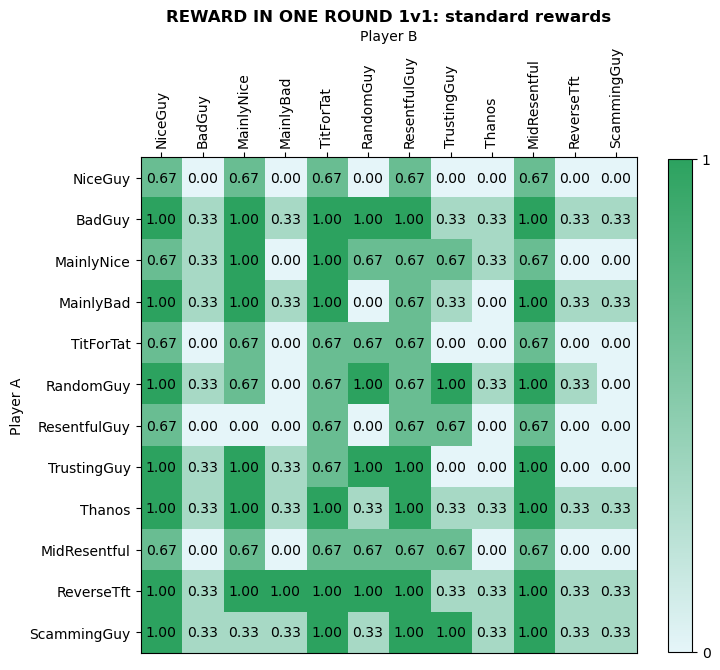

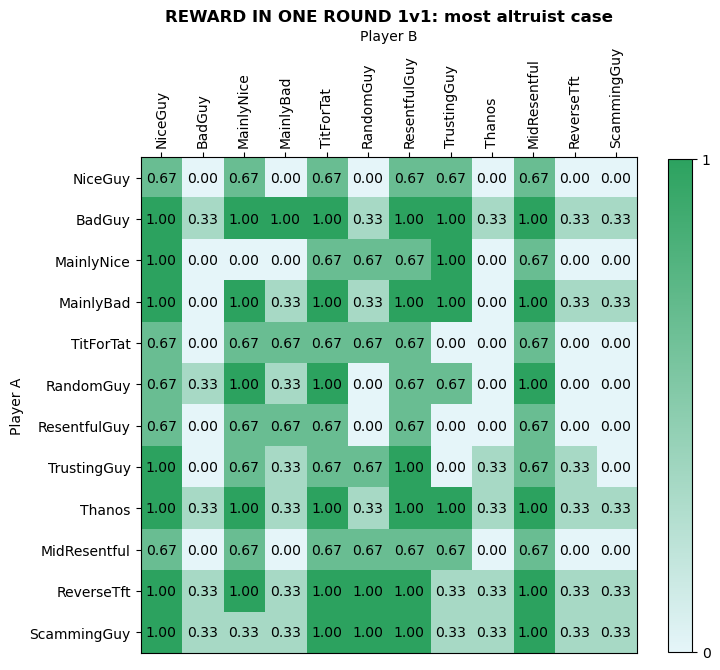

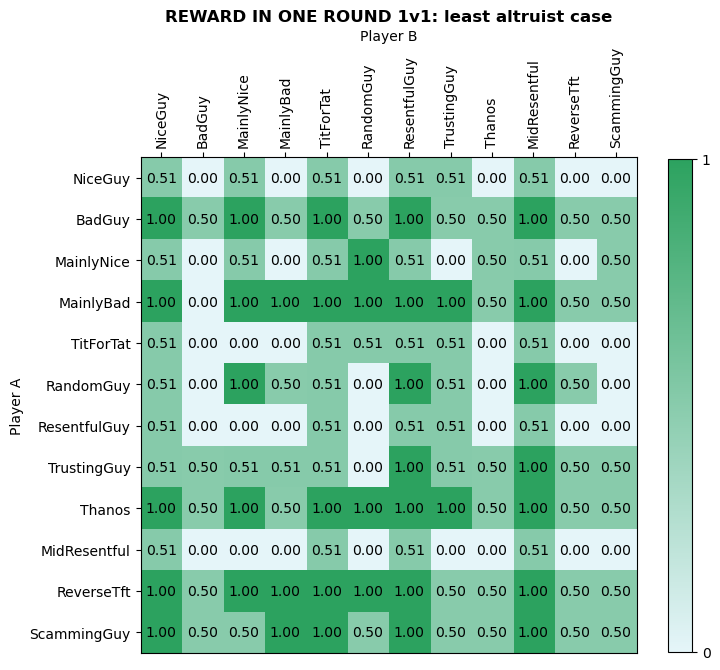

In [21]:
# Creiamo una colormap che va da verde scuro a verde chiaro (usando i codici XKCD dei colori):
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green", [ "#e5f5f9", "#2ca25f"])

# Etichette per gli assi con nomi delle strategie:
strategy_names = list(strategies.keys())

def plot_rounds(matrix):
    # first we initialize the matrix of rewards: it will be a list that contains the lists with the rewards for each strategy
    # so for example the first row will contain all the rewards of the first strategy vs all strategies (in a 1 turn game each)
    table_rewards = []
    # cycle over all strategies:
    for i, key_1 in enumerate(strategies):
        table_rewards.append([])             # I add a row for each  strategy
        for j, key_2 in enumerate(strategies):
            a, b = round(key_1, key_2, round_number=0, match_history=[[]], M = matrix)
            table_rewards[i].append(a)
    
    # PLOT of the tables:
    fig, ax = plt.subplots(1, 1 ,figsize=(8,8))
    # creiamo il plot con plt.imshow():
    graph = ax.imshow(table_rewards, cmap=custom_cmap)
    cbar = plt.colorbar(graph, shrink=0.8)
    # Imposta la colorbar per mostrare solo valori interi
    cbar.locator = ticker.MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.xticks( ticks=np.arange(len(strategy_names)), labels=strategy_names, rotation=90 )  # rotation for vertical labels
    plt.yticks( ticks=np.arange(len(strategy_names)), labels=strategy_names)
    ax.xaxis.set_label_position('top')     # sposto in alto l'asse x
    ax.xaxis.tick_top()                    # sposto in alto i labels dell'asse x
    # Scriviamo i valori numerici nelle celle:
    for i in range(len(strategy_names)):
        for j in range(len(strategy_names)):
            # j,i are inverted because in matplotlib, like in cartesian coordinates, x refers to ascisse so columns, y to ordinate so rows
            # 'ha and 'va' are horizontal and vertical alignment
            plt.text(j, i, f"{table_rewards[i][j]:.2f}", ha='center', va='center', color='black')
    if  (np.array_equal(matrix,Payoff)):     plt.title("REWARD IN ONE ROUND 1v1: standard rewards", fontweight='bold')
    elif(np.array_equal(matrix,Most_Altruist)): plt.title("REWARD IN ONE ROUND 1v1: most altruist case", fontweight='bold')
    elif(np.array_equal(matrix,Least_Altruist)):  plt.title("REWARD IN ONE ROUND 1v1: least altruist case", fontweight='bold')
    plt.xlabel("Player B")
    plt.ylabel("Player A")
    plt.show()

matrixes = [Payoff, Most_Altruist, Least_Altruist]
for matrix in matrixes: plot_rounds(matrix)

COMMENT: As we can see, excluding random noise due to strategies relying on casual input, the evident winning move for 1 round is to **defect** (see reward rows for BadGuy, Thanos, ReverseTft...) instead altruist strategies like NiceGuy are losing ones. This is excpeted because, in the standard rewards example, in a 1-turn game logically we have two possibilities: by cooperating we could get 2 or 0 as rewards, but by defecting 3 or 1.

### MATCHES 1 Vs 1 - ALL COMBINATIONS
Let's build a table of all possible 1 Vs 1 single match result, changing also the payoff matrixes previously chosen.

In [24]:
N = 10        # number of rounds

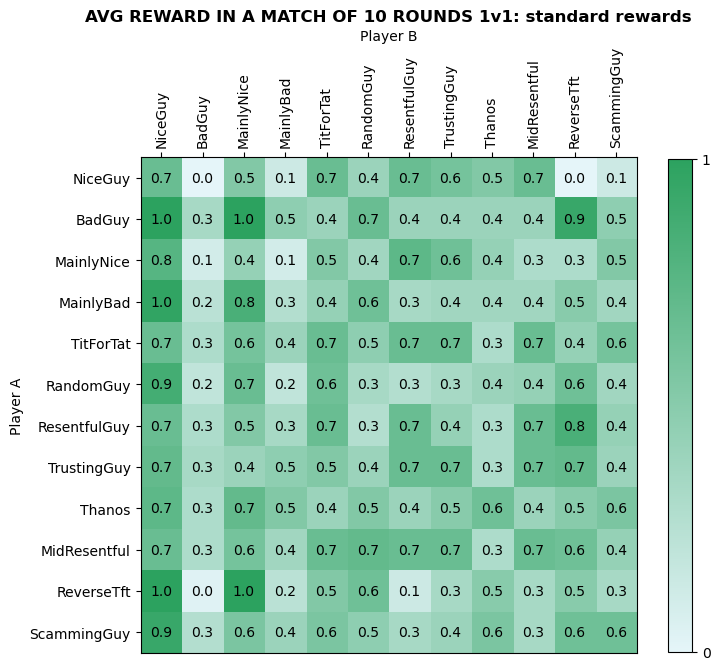

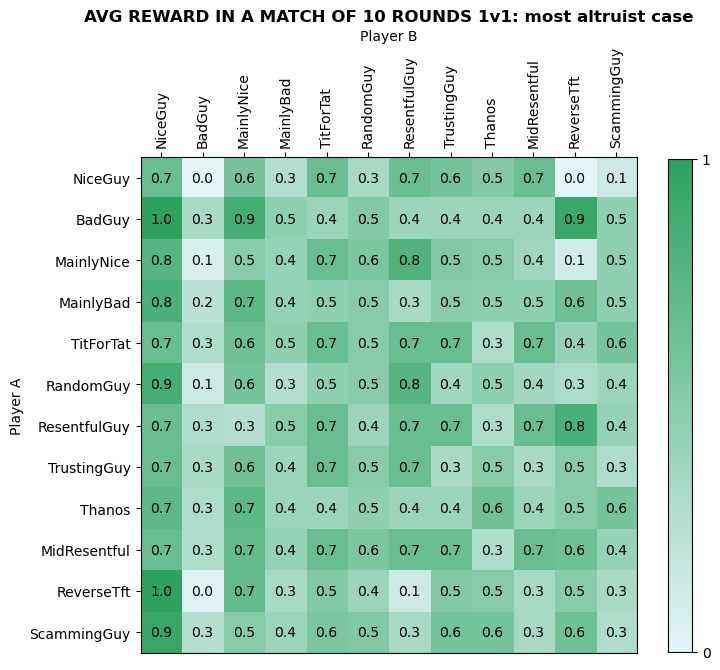

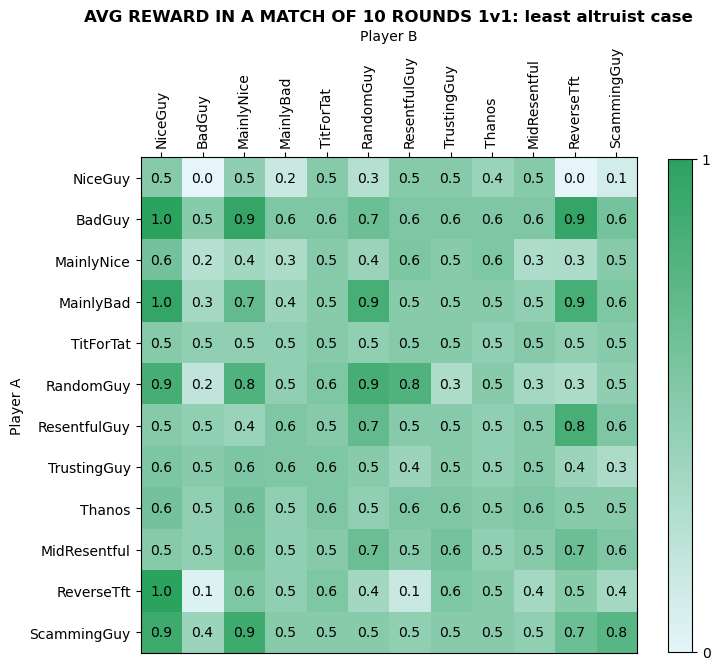

In [22]:
def plot_matches(matrix):
    table_rewards = []               # let's initialize the matrix of rewards of 1v1 rounds for all strategies: dim=(num_strateg)x(num_strateg)
    table_partial_rewards = []       # matrix of partial rewards, for the graphs. dim=(num_strateg)x(num_strateg)xNx2
     
    # cycle over all strategies:
    for i, key_1 in enumerate(strategies):
        table_rewards.append([])             # I add a row for each  strategy
        table_partial_rewards.append([])
        for j, key_2 in enumerate(strategies):
            rew = match(key_1, key_2, N, M = matrix )   # memo: it returns a chronological list of partial rewards
            table_rewards[i].append(rew[-1][0])  
            for round in range(N):
                rew[round][0] *= (round + 1)
                rew[round][1] *= (round + 1)
            table_partial_rewards[i].append(rew)
    
    
    # PLOT of matches rewards (as before):
    fig, ax = plt.subplots(1, 1 ,figsize=(8,8))
    graph = ax.imshow(table_rewards, cmap=custom_cmap)
    cbar = plt.colorbar(graph, shrink=0.8)
    # Imposta la colorbar per mostrare solo valori interi
    cbar.locator = ticker.MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.xticks( ticks=np.arange(len(strategy_names)), labels=strategy_names, rotation=90 ) 
    plt.yticks( ticks=np.arange(len(strategy_names)), labels=strategy_names)
    ax.xaxis.set_label_position('top')  
    ax.xaxis.tick_top()  
    # Inseriamo i valori nelle celle:
    for i in range(len(strategy_names)):
        for j in range(len(strategy_names)):
            plt.text(j, i, f"{table_rewards[i][j]:.1f}", ha='center', va='center', color='black')
    if  (np.array_equal(matrix,Payoff)):     plt.title(f"AVG REWARD IN A MATCH OF {N} ROUNDS 1v1: standard rewards", fontweight='bold')
    elif(np.array_equal(matrix,Most_Altruist)): plt.title(f"AVG REWARD IN A MATCH OF {N} ROUNDS 1v1: most altruist case", fontweight='bold')
    elif(np.array_equal(matrix,Least_Altruist)):  plt.title(f"AVG REWARD IN A MATCH OF {N} ROUNDS 1v1: least altruist case", fontweight='bold')
    plt.xlabel("Player B")
    plt.ylabel("Player A")
    plt.show()
    return table_partial_rewards

tables = []                                          # here we wil save the table_partial_rewards for future plot
for matrix in matrixes: 
    tables.append(plot_matches(matrix))

COMMENT: Also in matches the conclusion is the same: defecting strategies (like BadGuy, Thanos, ReverseTft...) are winning strategies, instead strategies like NiceGuy are losing strategies. This is also expected because for now the goal is to win the match (we are not focusing in the total amount of rewards) so the case of (3,1) rewards given to defecting moves are always (=at every turn) more appealing than cooperating (= possible rewards (2,0)).

MORAL: in a world with only 1 other competitor, the best choice is to defect.

### MATCHES BEHAVIOUR
We want to visualize some meaningful graphs showing the trend of rewards of the matches over the sequence of rounds. The focus is to highlight the qualitative behaviour of the strategies during a match.

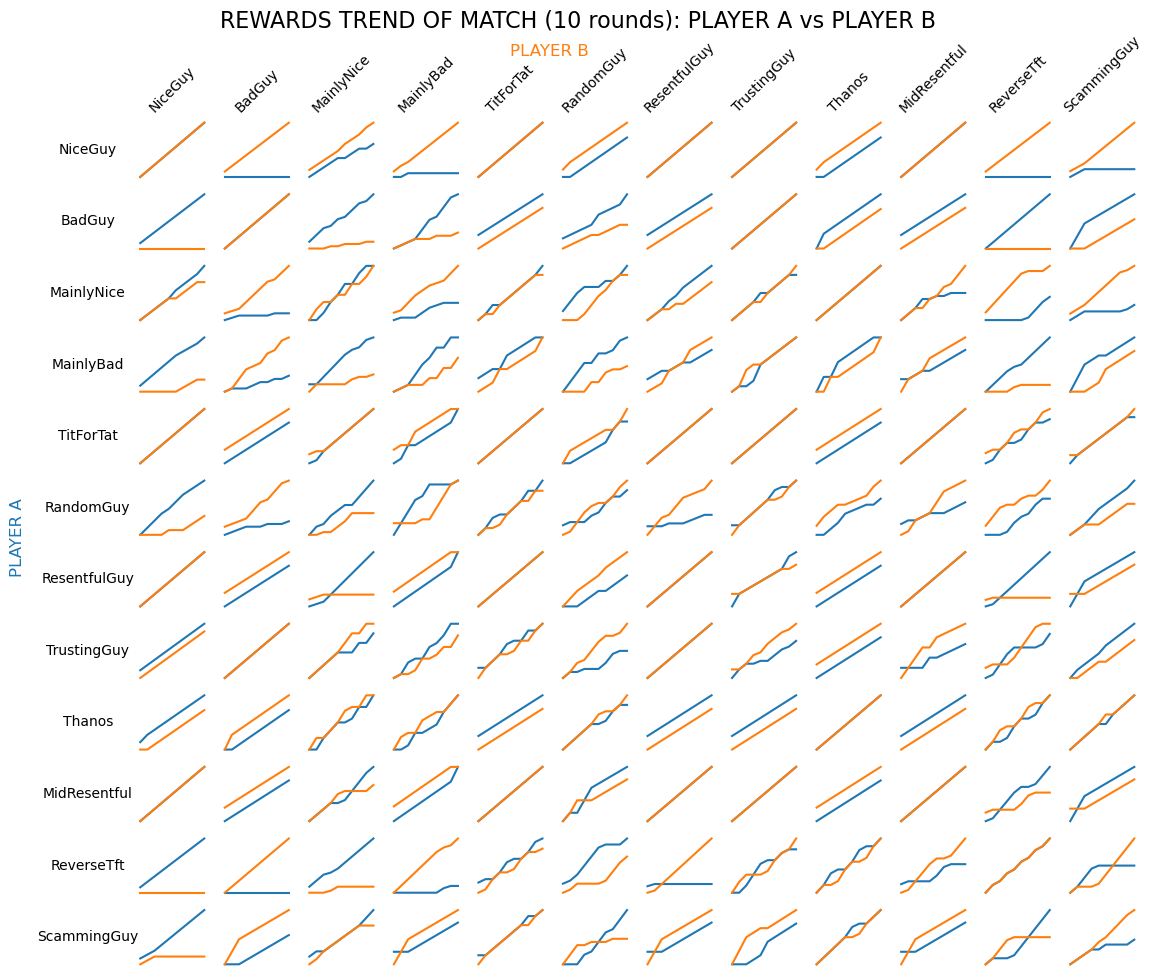

In [12]:
# PLOT of partial rewards to see the evolution of matches:

strategy_names = list(strategies.keys())                              # list with the strategy names
num_strat = len(strategies)                                           # number of strategies

def plot_matches_trend(table_partial_rewards):
    fig, axs = plt.subplots(num_strat, num_strat+1 ,figsize=(14,11))      # one more column for writing strategy names
    x_axis = np.arange(N)          # array for x axis plots
    
    # let's plot graphs:
    for i in range(num_strat):
        for j in range(1, num_strat+1):
            rew_i, rew_j = zip( *table_partial_rewards[i][j-1] )         # extrapolate array of rewards for the two strategies
            # print(type(rew_i))
            # for round in range(N):
            #     rew_i[round] = rew_i[round] * (round + 1) 
            #     rew_j[round] = rew_j[round] * (round + 1)
            axs[i][j].plot(x_axis, rew_i)
            axs[i][j].plot(x_axis, rew_j)
            axs[i][j].axis("off")                                          # remove axes and values for clarity
    
    # let's write strategy names on x axis:
    for j in range(num_strat):
        axs[0][j+1].set_title(f"{strategy_names[j]}", rotation=45, fontsize=10)         # rotation for clarity
    
    # let's write strategy names in blank first column of graphs (so on y axis)
    for i in range(num_strat):
        axs[i][0].axis("off") 
        axs[i][0].text(0.5,0.5,f"{strategy_names[i]}", ha='center', va='center', color='black')
    
    # overall title and axis names
    fig.suptitle(f"REWARDS TREND OF MATCH ({N} rounds): PLAYER A vs PLAYER B", fontsize=16)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig.text(0.48, 0.942, 'PLAYER B', color=colors[1], ha='center', va='center', fontsize=12)  # Asse X
    fig.text(0.1, 0.5, 'PLAYER A', color=colors[0], ha='center', va='center', rotation='vertical', fontsize=12)  # Asse Y

# let's only plot the result for standard rewards (for clarity):
plot_matches_trend(tables[0])

COMMENT:
For a low number of rounds (N < 40), the differences in strategy performance are clearly visible in multiple nuances, showing shifts and "overtakes." However, with a high number of rounds (N > 40), the graphs do not display significant peculiarities, mostly dividing into two classes: those that are roughly evenly matched (i.e., strategies that align with the opponent) and others that overwhelmingly win or lose (e.g., BadGuy vs. NiceGuy).
This was predictable, as many of the strategies used - excluding the "fixed" ones (NiceGuy, BadGuy, RandomGuy, etc.)- make particular decisions mainly in the early rounds (a sort of transient phase), before almost always settling into a fixed strategy.

Let's zoom now on the matches of a defecting strategy like BadGuy:

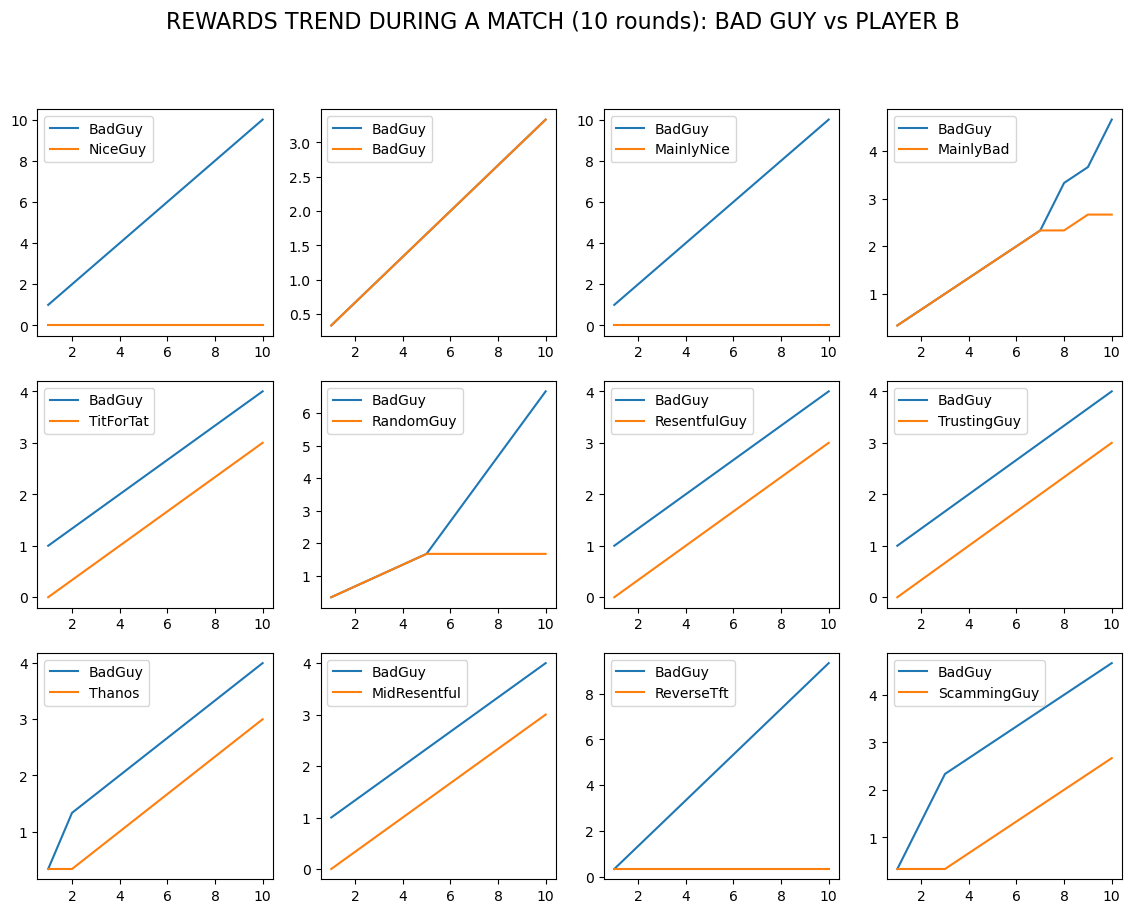

In [26]:
# PLOT of bad_guy matches

def plot_bad_guy_matches(table_partial_rewards):
    fig, axs = plt.subplots(3, 4 ,figsize=(14,10))      
    x_axis = np.arange(1, N+1)                                                 # array for x axis plots
    
    # let's plot graphs:
    k_i = 0
    for i in range(3):
        for j in range(4):
            rew_i, rew_j = zip( *table_partial_rewards[1][k_i] )           # extrapolate array of rewards for the two strategies
            axs[i][j].plot(x_axis, rew_i, label="BadGuy")
            axs[i][j].plot(x_axis, rew_j, label=f"{strategy_names[k_i]}")
            axs[i][j].legend()
            k_i = k_i +1
            
    # overall title:
    fig.suptitle(f"REWARDS TREND DURING A MATCH ({N} rounds): BAD GUY vs PLAYER B", fontsize=16)


plot_bad_guy_matches(tables[0])

COMMENT: as said before, defecting strategies (like BadGuy above) are winning strategies. In our example the bad guy is winning every match, except a draw with himself.